<h1><center>Acrobot - RK4</center></h1>

In [1]:
import meshcat
import meshcat.geometry as geom
import meshcat.transformations as tf
import numpy as np
import time
import jax.numpy as jnp
import jax
from jaxlie import SE2, SE3
import matplotlib.pyplot as plt
import math

In [2]:
vis = meshcat.Visualizer()
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
########################################## Parameters ##########################################
_m1 = 10 #mass
_m2 = 10

_l1 = 1 #lenght+
_l2 = 1

I1 = 1/3 * _m1 * _l1**2 #Inertia
I2 = 1/3 * _m2 * _l2**2

dt = 1e-4 # 1e-4 #time step
_g = 9.81 #gravity
steps = 10000 # iterations

### link 1 ###
q1 = 0.35 #rads
q_dot1 = 0 #rads/s
T1 = 0

### link 2 ###
q2 = 0
q_dot2 = 0
T2 = 0

#### Using the equations in https://underactuated.csail.mit.edu/acrobot.html

In [11]:
T = np.array([ T1, T2 ])
q = np.array([ q1, q2 ])
q_dot = np.array([ q_dot1, q_dot2 ])

def mass_matrix(q):
    m11 = I1 + I2 + _m2 * (_l1 ** 2) + 2 * _m2 * _l1 * _l2 * np.cos(q[1])
    m12 = I2 + _m2 * _l1 * _l2 * np.cos(q[1])
    m21 = I2 + _m2 * _l1 * _l2 * np.cos(q[1])
    m22 = I2
    return np.array([ [m11, m12], [m21, m22] ])
    
def coriolis(q, q_dot):
    c11 = -2 * _m2 * _l1 * _l2 * np.sin(q[1]) * q_dot[1]
    c12 = -_m2 * _l1 * _l2 * np.sin(q[1]) * q_dot[1]
    c21 = _m2 * _l1 * _l2 * np.sin(q[1]) * q_dot[0]
    c22 = 0.0

    return np.array([ [c11, c12], [c21, c22] ])
    
def gravy(q):
    _lc1 = _l1 / 2
    _lc2 = _l2 / 2
    g1 = -_m1 * _g * _lc1 * np.sin(q[0]) - _m2 * _g * (_l1 * np.sin(q[0]) + _lc2 * np.sin(q[0] + q[1]))
    g2 = -_m2 * _g * _lc2 * np.sin(q[0] + q[1])
    return np.array([g1, g2])


def euler(dt, q, q_dot, q_ddot):
    q_dot = q_dot + (q_ddot * dt)
    q = q + (q_dot * dt)
    
    return q, q_dot
    
################################################ Try ############################################
def angular(q, q_dot):
    q_ddot = np.linalg.inv(mass_matrix(q)) @ (T - coriolis(q, q_dot) @ q_dot - gravy(q))
    return q_ddot

def f(y):
    q = y[:2]
    q_dot = y[2:]
    q_ddot = angular(q, q_dot)
    return np.concatenate((q_dot, q_ddot))

def rk4(y, dt):
    k1 = f(y)
    k2 = f(y + dt * k1/2)
    k3 = f(y + dt * k2/2)
    k4 = f(y + dt * k3)
    return y + (dt/6) * (k1 + 2 * k2 + 2 * k3 + k4)


### Kinetic and Potential Energy 

In [12]:
################################################ For Graphing ############################################
kinetic_list = []
potential_list = []

m = np.array([_m1, _m2])

def kinetic(q, q_dot):
    K = 0.5 * I1 * q_dot[0]**2 + 0.5 * I2 * (q_dot[0] + q_dot[1])**2 + 0.5 * _m2 * (_l1**2) * q_dot[0]**2 + _m2 * _l1 * _l2 * q_dot[0] * (q_dot[0] + q_dot[1]) * np.cos(q[1])
    return K
 
def potential(q):
    U = -_m1 * _g * (_l1 / 2) * np.cos(q[0]) - _m2 * _g * (_l1 * np.cos(q[0]) + (_l2 / 2) * np.cos(q[0] + q[1]))
    return U

### Simulation

In [5]:
### pivot 1 ### 
pivot_1 = vis["base_pivot"].set_object(geom.Sphere(0.01))
### link 1 ###
link = vis["pendulum_link"]
link.set_object(geom.Box([0.01, 0.01, -_l1]))

### pivot 2 ###
vis["base_pivot_2"].set_object(geom.Sphere(0.01))
### link 2 ###
link2 = vis["pendulum_link_2"]
link2.set_object(geom.Box([0.01, 0.01, -_l2]))

######################### Animation RK4 Method #########################
y = np.array([q1, q2, q_dot1, q_dot2])
for t in range(steps):
    q_ddot = angular(q, q_dot)
    y = rk4(y, dt)
    q = y[:2]
    q_dot = y[2:]
    #print(q[0], q[1], q_dot[0], q_dot[1])
    K = kinetic(q, q_dot)
    U = potential(q)

    kinetic_list.append(K)
    potential_list.append(U)

    if t % 50 == 0:

        ### link 1 ### 
        r_1 = tf.rotation_matrix(q[0], [0, 1, 0])
        t_1 = tf.translation_matrix([0.0, 0.0, -(_l1 / 2)])
    
        vis["pendulum_link"].set_transform(np.dot(r_1, t_1))
    
    ### pivot 2 ###
        pt_2 = tf.translation_matrix([0.0, 0.0, - _l1])
        vis["base_pivot_2"].set_transform(np.dot(r_1, tf.translation_matrix([0.0, 0.0, - _l1])))

    ### link 2 ###
        t_2 = np.dot(r_1, tf.translation_matrix([0.0, 0.0, -_l1]))  # relative to origin
        r_2 = tf.rotation_matrix(q[1], [0.0, 1.0, 0.0])
        t2 = tf.translation_matrix([0.0, 0.0, -_l2/2])

        vis["pendulum_link_2"].set_transform(np.dot(t_2, np.dot(r_2, t2)))
        
    time.sleep(dt)

C:\Users\Alex1\AppData\Local\Temp\ipykernel_20900\2375622254.py:36: RuntimeWarning: overflow encountered in matmul
  q_ddot = np.linalg.inv(mass_matrix(q)) @ (T - coriolis(q, q_dot) @ q_dot - gravy(q))
C:\Users\Alex1\AppData\Local\Temp\ipykernel_20900\2375622254.py:36: RuntimeWarning: invalid value encountered in matmul
  q_ddot = np.linalg.inv(mass_matrix(q)) @ (T - coriolis(q, q_dot) @ q_dot - gravy(q))
C:\Users\Alex1\AppData\Local\Temp\ipykernel_20900\2375622254.py:6: RuntimeWarning: invalid value encountered in cos
  m11 = I1 + I2 + _m2 * (_l1 ** 2) + 2 * _m2 * _l1 * _l2 * np.cos(q[1])
C:\Users\Alex1\AppData\Local\Temp\ipykernel_20900\2375622254.py:7: RuntimeWarning: invalid value encountered in cos
  m12 = I2 + _m2 * _l1 * _l2 * np.cos(q[1])
C:\Users\Alex1\AppData\Local\Temp\ipykernel_20900\2375622254.py:8: RuntimeWarning: invalid value encountered in cos
  m21 = I2 + _m2 * _l1 * _l2 * np.cos(q[1])
C:\Users\Alex1\AppData\Local\Temp\ipykernel_20900\2375622254.py:13: RuntimeWarning:

In [6]:
time = list(range(steps))

Text(0.5, 1.0, 'Kinetic Energy over Steps')

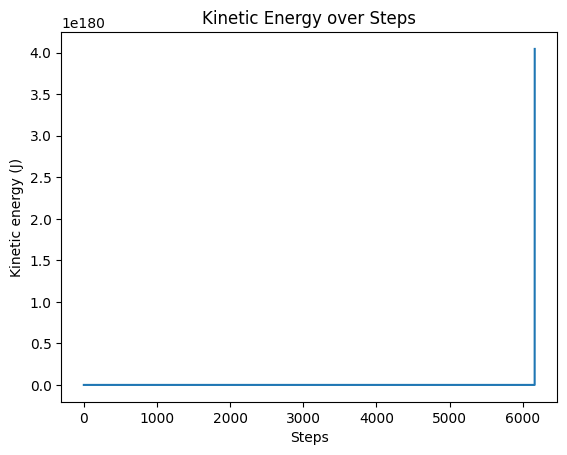

In [7]:
plt.plot(time, kinetic_list)
plt.xlabel("Steps")
plt.ylabel("Kinetic energy (J)")
plt.title("Kinetic Energy over Steps")

Text(0.5, 1.0, 'Potential Energy over Steps')

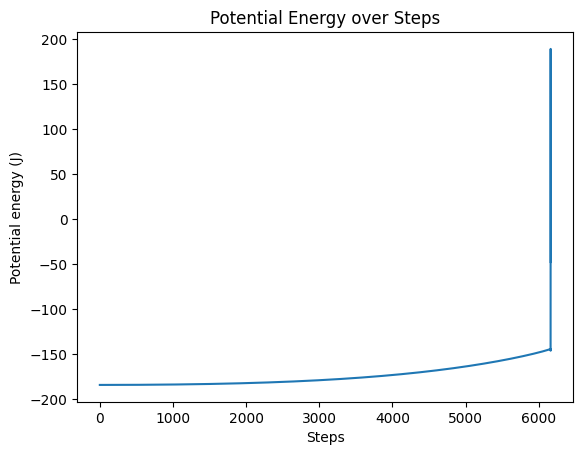

In [8]:
plt.plot(time, potential_list)
plt.xlabel("Steps")
plt.ylabel("Potential energy (J)")
plt.title("Potential Energy over Steps")

Text(0.5, 1.0, 'Total Energy over Time')

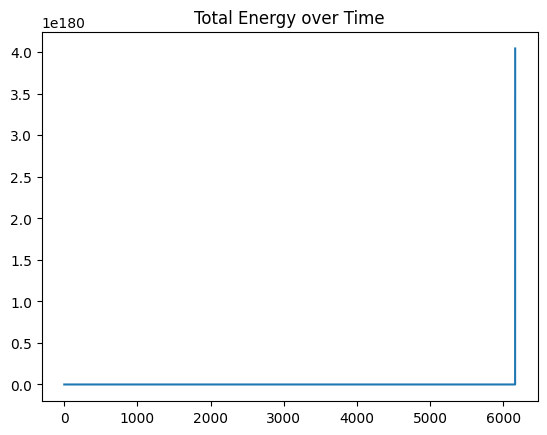

In [9]:
E = (np.array(kinetic_list) - np.array(potential_list)).tolist()
plt.plot(time, E)
plt.title("Total Energy over Time")

In [10]:
threshold = 1e6

for i in range(1, len(E)):
    diff = abs(E[i] - E[i-1])
    if math.isnan(E[i]) or diff > threshold:
        print(f"Anomaly at step {i}: value={E[i]}, diff from previous={diff}")
        break


Anomaly at step 6163: value=-2571180831.5224147, diff from previous=2571181015.7596602
